<a href="https://colab.research.google.com/github/scunning706/Appraising-Used-Cars/blob/main/Used_Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Used Car Sales 

Data: https://www.kaggle.com/ananaymital/us-used-cars-dataset

In this notebook, we will address these questions:
1. Create a model to predict price of used cars
2. What factors play a role in the price of a used car?

##Imports

In [ ]:
import pandas as pd # Used for loading and manipulating data
import numpy as np # Numerical Python = used for computations
from matplotlib import pyplot as plt # Used for graphing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/Shared drives/Project 4 (MATH 3439)/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data Loading

Our data cannot all be loaded at once because it takes up too much RAM. We did end up loading it in chunks but for the purpose of this notebook we will only be loading 100,000 rows to do some of the analysis below.


Our data is too large to load in all at once, we will not have enough ram, and must find other ways to work with the data. 

In [ ]:
#This is not gonna run, so we'll need to look at a subset of the data
#df = pd.read_csv(drive_dir + 'used_cars_data.csv')

The first approach is to create chunks of data that we can clean and then combine once memory usage is decreased. Our data set has 3 million cars and this saves the cars into 3 chunks of a million cars each.

In [ ]:
#Do not run again already saved in drive
chunk_size=1000000
batch_no=1
#for chunk in pd.read_csv(drive_dir + 'data/used_cars_data.csv',chunksize=chunk_size, usecols = ['back_legroom', 'body_type',
       'wheel_system', 'city', 'city_fuel_economy',
       'daysonmarket', 'description', 
       'engine_displacement', 'engine_type',  'fleet',
       'frame_damaged', 'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_new', 'latitude', 'length',
       'listed_date', 'listing_color', 'longitude',
        'major_options', 'make_name', 'maximum_seating',
       'mileage', 'model_name', 'owner_count', 'power', 'price', 'salvage',
       'savings_amount', 'seller_rating',  'sp_name', 'theft_title',
       'torque', 'transmission', 'transmission_display',  'trim_name',
       'wheelbase', 'width', 'year']):
    chunk.to_csv(drive_dir + 'data/' + 'chunk'+str(batch_no)+'.csv',index=False)
    batch_no+=1

We can also load in a small subset of the data for anaysis and exploratory purposes.

In [ ]:
df_mini = pd.read_csv(drive_dir + 'data/used_cars_data.csv', nrows=100000, skiprows= range(1,1000000), usecols = ['back_legroom', 'body_type',
       'wheel_system', 'city', 'city_fuel_economy',
       'daysonmarket', 'description', 
       'engine_displacement', 'engine_type',  'fleet',
       'frame_damaged', 'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_new', 'latitude', 'length',
       'listed_date', 'listing_color', 'longitude',
        'major_options', 'make_name', 'maximum_seating',
       'mileage', 'model_name', 'owner_count', 'power', 'price', 'salvage',
       'savings_amount', 'seller_rating',  'sp_name', 'theft_title',
       'torque', 'transmission', 'transmission_display',  'trim_name',
       'wheelbase', 'width', 'year'])

In [ ]:
df_mini.head()

,back_legroom,body_type,city,city_fuel_economy,daysonmarket,description,engine_displacement,engine_type,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,highway_fuel_economy,horsepower,interior_color,isCab,is_new,latitude,length,listed_date,listing_color,longitude,major_options,make_name,maximum_seating,mileage,model_name,owner_count,power,price,salvage,savings_amount,seller_rating,sp_name,theft_title,torque,transmission,transmission_display,trim_name,wheel_system,wheelbase,width,year
0,34.5 in,Pickup Truck,Washington Court House,20.0,252,NaN,2300.0,I4,False,False,True,Ford,43.1 in,18 gal,Gasoline,False,71.8 in,24.0,270.0,None,False,True,39.5518,210.8 in,2020-01-02,BLACK,-83.4217,"['Sport Package', '301A Mid Equipment Group', ...",Ford,5 seats,0.0,Ranger,NaN,NaN,38705.0,False,0,4.000000,Beford Ford,False,NaN,A,Automatic,XLT SuperCrew 4WD,4WD,126.8 in,85.8 in,2020
1,38.3 in,Sedan,Washington Court House,22.0,6,NaN,2000.0,I4,True,False,True,Ford,44.3 in,16.5 gal,Gasoline,True,58.2 in,34.0,240.0,None,True,False,39.5518,191.7 in,2020-09-04,WHITE,-83.4217,"['Sunroof/Moonroof', 'SE Package', 'Alloy Whee...",Ford,5 seats,85300.0,Fusion,3.0,"240 hp @ 5,500 RPM",12490.0,False,640,4.000000,Beford Ford,False,"270 lb-ft @ 1,750 RPM",A,Automatic,SE,FWD,112.2 in,83.5 in,2016
2,32.6 in,Pickup Truck,Groveport,18.0,6,"Click the Express button, Free home delivery o...",3500.0,V6,False,False,False,NaN,42.9 in,21.1 gal,Gasoline,False,70.6 in,22.0,278.0,Cement Gray,False,False,39.8881,212.3 in,2020-09-04,WHITE,-82.8833,['Backup Camera'],Toyota,5 seats,18320.0,Tacoma,1.0,"278 hp @ 6,000 RPM",33888.0,False,4,4.211765,Ricart Used Car Factory,False,"265 lb-ft @ 4,600 RPM",A,6-Speed Automatic,SR V6 Double Cab 4WD,4WD,127.4 in,74.4 in,2019
3,43.6 in,Pickup Truck,Groveport,18.0,65,"Click the Express button, Free home delivery o...",3500.0,V6,False,False,False,NaN,43.9 in,23 gal,Gasoline,True,76.9 in,23.0,375.0,Black,False,False,39.8881,231.9 in,2020-07-07,RED,-82.8833,"['Navigation System', 'Alloy Wheels', 'Bluetoo...",Ford,6 seats,29917.0,F-150,1.0,"375 hp @ 5,000 RPM",35890.0,False,97,4.211765,Ricart Used Car Factory,False,"470 lb-ft @ 2,500 RPM",A,6-Speed Automatic,XLT SuperCrew 4WD,4WD,145 in,96.8 in,2017
4,31.2 in,Hatchback,Washington Court House,27.0,253,[!@@Additional Info@@!]Backup CameraRear View ...,1600.0,I4,False,False,True,Ford,43.6 in,12.4 gal,Gasoline,False,58.1 in,37.0,120.0,None,False,False,39.5518,159.7 in,2020-01-01,UNKNOWN,-83.4217,"['Power Package', 'SE Package', 'Alloy Wheels'...",Ford,5 seats,4230.0,Fiesta,1.0,"120 hp @ 5,000 RPM",14400.0,False,588,4.000000,Beford Ford,False,"112 lb-ft @ 5,000 RPM",A,Automatic,SE Hatchback FWD,FWD,98 in,77.8 in,2019


Here is the total memory usage which is manageable for our analysis below.

In [ ]:
df_mini.memory_usage().sum()/10**6

37.000128

## Cleaning Data

This is some initial data cleaning for the columns that we wanted to be integers and weren't because of units.

Since our data was so large we used the information provided on Kaggle to not load in any columns that had a large majority of null values. We dropped columns `vehicle_damage_category`, `is_cpo`,`is_certified`,`combine_fuel_economy`, `cabin`, and `bed` as these columns are missing over 90% of their data. 

In [ ]:
for c in df_mini.columns:
    num_missing = df_mini[c].isna().sum()
    if num_missing > 0:
        print(f'{c}: {num_missing} ({100*num_missing / df_mini.shape[0]:.2f}%) missing values')

back_legroom: 4720 (4.72%) missing values
body_type: 453 (0.45%) missing values
city_fuel_economy: 16523 (16.52%) missing values
description: 2727 (2.73%) missing values
engine_displacement: 5235 (5.24%) missing values
engine_type: 3179 (3.18%) missing values
fleet: 47627 (47.63%) missing values
frame_damaged: 47627 (47.63%) missing values
franchise_make: 17452 (17.45%) missing values
front_legroom: 4720 (4.72%) missing values
fuel_tank_volume: 4720 (4.72%) missing values
fuel_type: 2918 (2.92%) missing values
has_accidents: 47627 (47.63%) missing values
height: 4720 (4.72%) missing values
highway_fuel_economy: 16523 (16.52%) missing values
horsepower: 5235 (5.24%) missing values
isCab: 47627 (47.63%) missing values
length: 4720 (4.72%) missing values
major_options: 6233 (6.23%) missing values
maximum_seating: 4720 (4.72%) missing values
mileage: 5065 (5.07%) missing values
owner_count: 50775 (50.77%) missing values
power: 15422 (15.42%) missing values
salvage: 47627 (47.63%) missing v

#### Stripping the Strings to be Integers
The columns of `back_legroom`,`front_legroom`,`fuel_tank_volume`,`height`,`length`, `maximum_seating`,`wheelbase` and `width` all include units in the data are are stored as objects. To help make the data smaller and analyze the values as continuous we will be removing the units and changing them to numeric types.  

In [ ]:
for col in df_mini:
  df_mini[col] = df_mini[col].replace('--', np.NaN)

In [ ]:
def removeUnits(df, column):
  df[column] = df[column].str.strip()
  df[column] = df[column].str.split(expand=True)

In [ ]:
columns_w_units = ['back_legroom','front_legroom','fuel_tank_volume','height','length', 'maximum_seating','wheelbase','width']
for column in columns_w_units:
  removeUnits(df_mini, column)

#### Splitting Power to store RPM's 

Currently the power is being stored as "177 hp @ 5,750 RPM", however we will want to analyze horsepower as a continuous variable. Thus we will be splitting this to 2 columns one for hp and one for RPM's. 

In [ ]:
def splitPower(df, column): 
  df[column] = df[column].str.strip()
  df['hp_rpm'] = df[column].str.rstrip('R').str.split('@').str[1] # Make new column

In [ ]:
splitPower(df_mini, 'power')
df_mini = df_mini.drop('power', 1) #drop column we dont need anymore
removeUnits(df_mini, 'hp_rpm') #remove RPM symbol
df_mini['hp_rpm'] = df_mini['hp_rpm'].str.replace(',','')

#### Method to convert torque (200 lb-ft @ 1,750 RPM)  to torque (200) and torque)rpm (1750) seperately

Currently the power is being stored as "200 lb-ft @ 1,750 RPM", however we will want to analyze horsepower as a continuous variable. Thus we will be splitting this to 2 columns one for torque and one for torque RPM's. 

In [ ]:
def splitTorque(df, column): 
  df[column] = df[column].str.strip()
  df['torque_rpm'] = df[column].str.rstrip('R').str.split('@').str[1] # Make new column
  removeUnits(df, column)
  removeUnits(df, 'torque_rpm') #remove RPM symbol
  df['torque_rpm'] = df['torque_rpm'].str.replace(',','')

In [ ]:
splitTorque(df_mini, 'torque')

#### Boolean Columns

This turns all of the true/false columns into 1/0 so that we can then make the data types smaller.

In [ ]:
le_col = ['frame_damaged', 'franchise_dealer', 'has_accidents','isCab', 'is_new', 'salvage', 'theft_title', 'fleet'  ]

for col in le_col:
  col_dict = {True:1, False:0}
  df_mini[col] = df_mini[col].map(col_dict)   #Mapping the dictionary
  #df_mini[col] = df_mini.astype(np.uint8)

## Feature Engineering

We decided to make a few extra columns since we dropped a lot of the non usuable columns.

###Make a column to count the null values

In [ ]:
df_mini['null_per_row'] = df_mini.isnull().sum(axis=1)

###This makes a rounded price column which rounds to the nearest 10,000.

In [ ]:
df_mini['rounded_price'] = round(df_mini['price'], -4)

###Column to count how many features a vehicle has

In [ ]:
def countItemsInText(df, column,newcolumn):
  df[newcolumn] = df[column].str.count(",") + 1

In [ ]:
countItemsInText(df_mini, 'major_options','options_count')

### Column to indicate if a vehicle has a listing color of Black or White

In [ ]:
df_mini['color_not_bw'] = np.where( ( (df_mini['listing_color'] == 'BLACK') | (df_mini['listing_color'] == 'WHITE')  ), 1, 0)

###Column that makes a simpler interior color

In [ ]:
df_mini['interior_simple_color'] = df_mini['interior_color'].str.split(' ').str[0]

### Column that tells us how many years since it was made

In [ ]:
df_mini['years_since_make'] = 2020-df_mini['year']

### Column that tallies whether or not a car has damage, accidents, or theft on it's record

In [ ]:
df_mini['damage_accidents_theft'] = df_mini['frame_damaged'] + df_mini['has_accidents'] + df_mini['theft_title']

###Column: is 4WD?

In [ ]:
conditions = [(df_mini['wheel_system'] == '4WD')]     #Sets the conditions
choices = [1]
df_mini['4WD'] = np.select(conditions, choices, 0)

###Column: Puts price into 10 buckets

In [ ]:
df_mini['percentile'] = pd.qcut(df_mini['price'], q=10, labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [ ]:
df_mini['percentile'] = df_mini['percentile'].astype(int)

## Dropping Nulls

Finally, we got to a point where we felt comfortable loading almost all of the data and dropping the null values. Some of the null values we were able to fill but the ones that were dropped did not affect the distribution of the cars in regards to price. The example below shows us doing it for df_mini for the purposes of keeping this notebooks RAM under control but to run this over the entire thing all that needs to be done is

- Load all of the data
- Run through the cleaning
- Drop columns and nulls and then delete the old version to save your RAM

These are columns that we want to fill in the median for the nulls.

In [ ]:
columns = ['back_legroom','city_fuel_economy',
       'daysonmarket', 'engine_displacement',
       'front_legroom', 'fuel_tank_volume',
       'height', 'highway_fuel_economy', 'horsepower',
        'length', 'maximum_seating', 'mileage',
       'savings_amount', 'seller_rating',
       'wheelbase', 'width', 'year']

for col in columns:
  df_mini[col] = df_mini[col].fillna((df_mini[col].median()))   #Median for Null Values

Next, we noticed that all of the nulls in the column owner count where identical to the is_New column. So we made them zero if they were null.

In [ ]:
df_mini['owner_count'] = df_mini['owner_count'].fillna(0)

Lastly, we realized that nulls in the boolean column might have a meaning so we assinged a null value to 2.

In [ ]:
bool_col = ['fleet', 'frame_damaged', 'franchise_dealer','has_accidents',
       'isCab', 'is_new', 'salvage', 'theft_title']

for col in bool_col:
  df_mini[col] = df_mini[col].fillna(2)

We also dropped description, franchise make, and torque because we realized they were duplicates or not necessary.

In [ ]:
col = ['description', 'franchise_make', 'torque']
df_mini = df_mini.drop(col, axis= 'columns')

Now we can drop all the rest of the NA values.

In [ ]:
df_mini = df_mini.dropna(how='any')   # Drop Nulls

In [ ]:
df_mini.isnull().sum()

back_legroom              0
body_type                 0
city                      0
city_fuel_economy         0
daysonmarket              0
engine_displacement       0
engine_type               0
fleet                     0
frame_damaged             0
franchise_dealer          0
front_legroom             0
fuel_tank_volume          0
fuel_type                 0
has_accidents             0
height                    0
highway_fuel_economy      0
horsepower                0
interior_color            0
isCab                     0
is_new                    0
latitude                  0
length                    0
listed_date               0
listing_color             0
longitude                 0
major_options             0
make_name                 0
maximum_seating           0
mileage                   0
model_name                0
owner_count               0
price                     0
salvage                   0
savings_amount            0
seller_rating             0
sp_name             

## Saving the Cleaned Data

Saving cleaned data into separate csv file, to make sure that we don't have to run everything again for just cleaning the data, when we work individually. 
So for individual work, we can just load 'uc_cleaned.csv' instead of our original data.

Take away the hashtag to run

In [ ]:
#df_mini.to_csv(drive_dir + 'data/df_mini.csv', index=False)

In [ ]:
del df_mini

## Loading in previously cleaned data for Analysis

We can now directly load the cleaned and smaller data so we can use it for the analysis. This is actual cleaned data from our analysis containing the first million rows.

In [ ]:
dtype_dict = {'back_legroom' : np.float32, 
              'city_fuel_economy' : np.float32,
              'daysonmarket' : pd.Int16Dtype(),
              'engine_displacement': pd.Int64Dtype(),
              'front_legroom':np.float32, 
              'fleet': pd.Int8Dtype(), 
              'frame_damaged': pd.Int8Dtype(),
              'franchise_dealer': pd.Int8Dtype(),
              'fuel_tank_volume': np.float32,
              'has_accidents': pd.Int8Dtype(),
              'height': np.float32,
              'highway_fuel_economy':pd.Int8Dtype(), 
              'horsepower': pd.Int16Dtype(),
              'isCab': pd.Int8Dtype(),
              'is_new': pd.Int8Dtype(), 
              'length':np.float32,
              'maximum_seating' : pd.Int8Dtype(),
              'mileage': np.float32, #pd.Int64Dtype(), 
              'owner_count':pd.Int8Dtype(), 
              'price': np.float32, #pd.Int64Dtype(),
              'salvage':pd.Int8Dtype(),
              'savings_amount' : np.float32, #pd.Int64Dtype(),
              'theft_title' : pd.Int8Dtype(), 
              'wheel_base': np.float32, 
              'width': np.float32, 
              'year': np.int16}


df_cleaned = pd.read_csv(drive_dir + 'data/uc_cleaned1.csv', dtype=dtype_dict)

The total memory usuage of df_cleaned is below.

In [ ]:
df_cleaned.memory_usage().sum()/10**6

263.000128

##Analysis

This is a brief analysis of some of the columns so we could identify the factors that place a role in the price of a used car.

###How does location play a role in price?

First let's see if a scatter plot of longitude or lattitude show a picture of the United States as a whole.

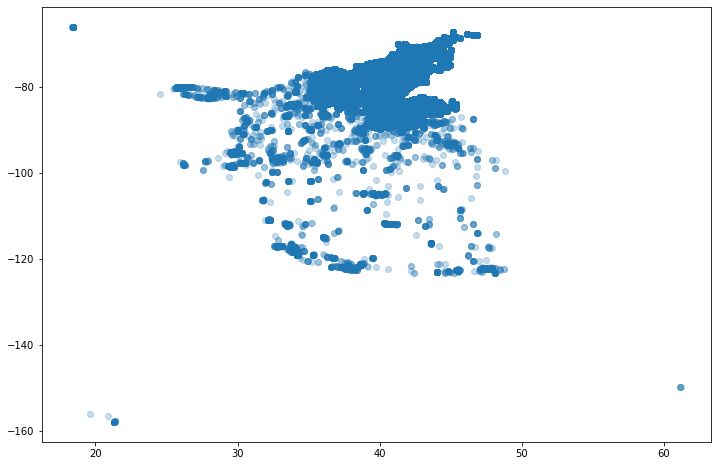

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(df_cleaned['latitude'], df_cleaned['longitude'], alpha=0.25);

Furthermore, let's look at subsets of the price. Specifically, less than \$50,000, between \$50,000 and \$100,000, and lastly greater than \$100,000.

In [ ]:
df_cleaned['rounded_price'] = round(df_cleaned['price'], -4)    # Round price to greatest ten thousand

In [ ]:
df_fifty = df_cleaned[df_cleaned['rounded_price'] <= 50000]         #Sepearting the dataframe
df_hundred = df_cleaned[df_cleaned['rounded_price'] <= 100000]
df_hundred = df_hundred[df_hundred['rounded_price'] > 50000]
df_greater_hundred = df_cleaned[df_cleaned['rounded_price'] > 100000]

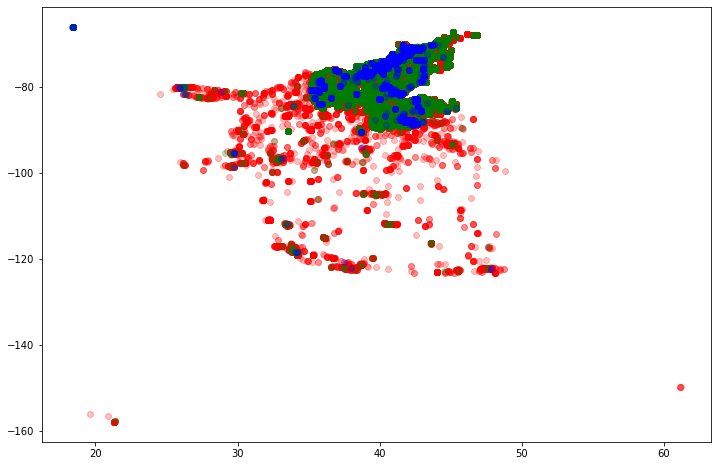

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(df_fifty['latitude'], df_fifty['longitude'], c='R', alpha=0.25)
plt.scatter(df_hundred['latitude'], df_hundred['longitude'], c='G', alpha=0.25)
plt.scatter(df_greater_hundred['latitude'], df_greater_hundred['longitude'], c='B', alpha=0.25);

We can see that less than \$50,000 is the most spread out but overall there seems to be a prime location for the used cars in the top right. Also notice Hawaii in the bottom left.

### How does type of car play a role in price?

Let's first group by body type and see if we can find the mean price for each.

In [ ]:
body_type_gb = df_cleaned.groupby(by='body_type')['price'].mean().sort_values(ascending=False)

As we can see below Convertible is the highest mean price while Hatchback is the lowest. This follows the general trend we would assume.

In [ ]:
body_type_gb

body_type
Convertible        46908.718750
Coupe              42432.566406
Pickup Truck       39943.242188
SUV / Crossover    30354.908203
Van                29434.904297
Minivan            24438.554688
Sedan              22290.882812
Wagon              20221.142578
Hatchback          17481.619141
Name: price, dtype: float32

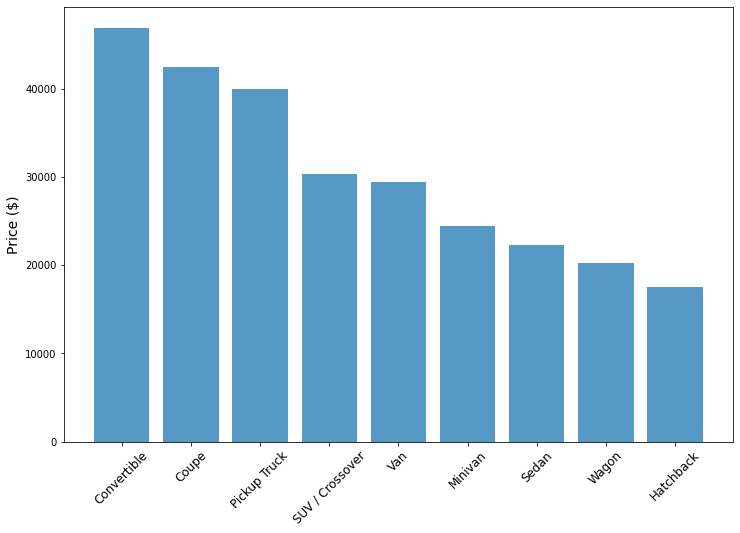

In [ ]:
plt.figure(figsize = (12,8))
plt.bar(body_type_gb.index, body_type_gb, alpha=0.75)
plt.ylabel('Price ($)', fontsize=14)
plt.xticks(rotation=45, fontsize=12);

Now let's look at make name.

In [ ]:
make_name_gb = df_cleaned.groupby(by='make_name')['price'].mean().sort_values(ascending=True)

These are the lowest prices and make sense considering a lot we have not heard of.

In [ ]:
make_name_gb.head(10)

make_name
Geo        3990.000000
Isuzu      4365.687500
Saturn     4809.792969
Edsel      5997.000000
Mercury    6055.006836
Suzuki     6084.217773
Saab       6634.004883
Scion      8849.126953
Daewoo     9010.000000
smart      9541.273438
Name: price, dtype: float32

A sloppy but interesting plot below. The next couple plots zoom in on this larger plot.

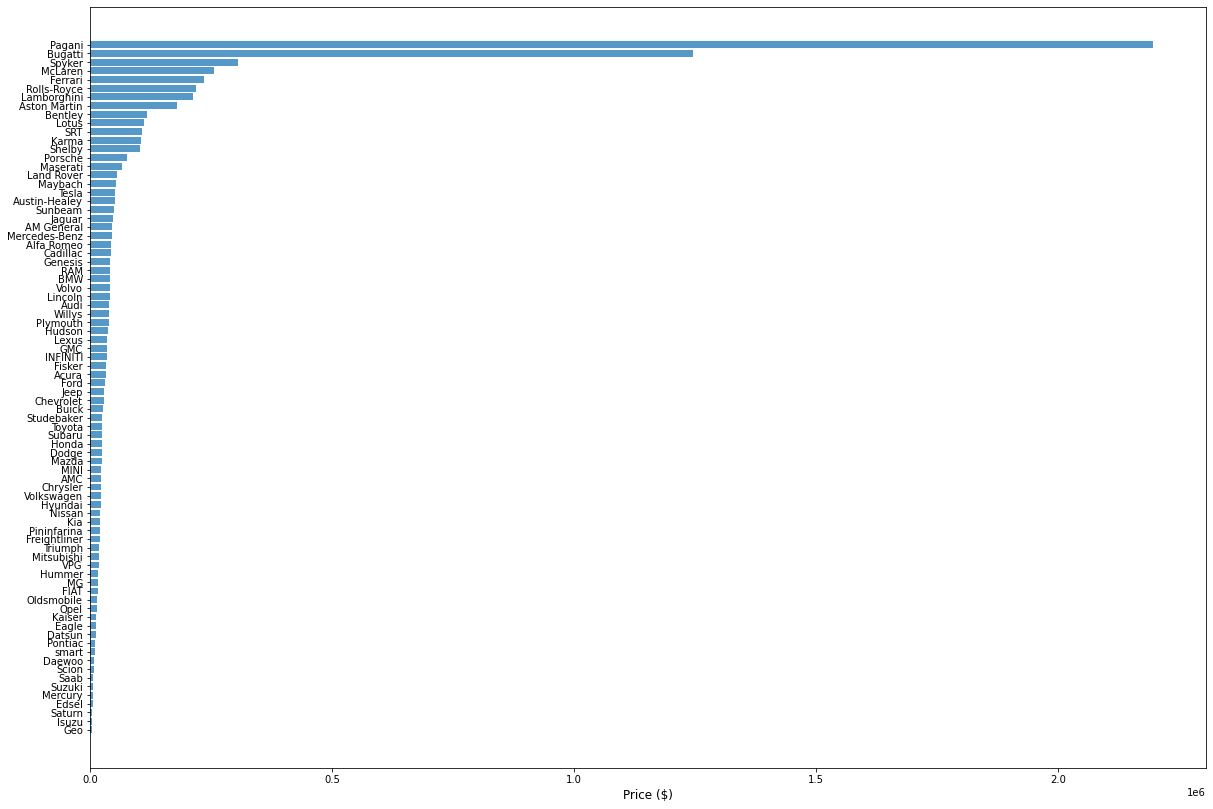

In [ ]:
plt.figure(figsize = (20,14))
plt.barh(make_name_gb.index, make_name_gb, alpha=0.75, )
plt.xlabel('Price ($)', fontsize=12);

Below is the 20 least expensive makes. 

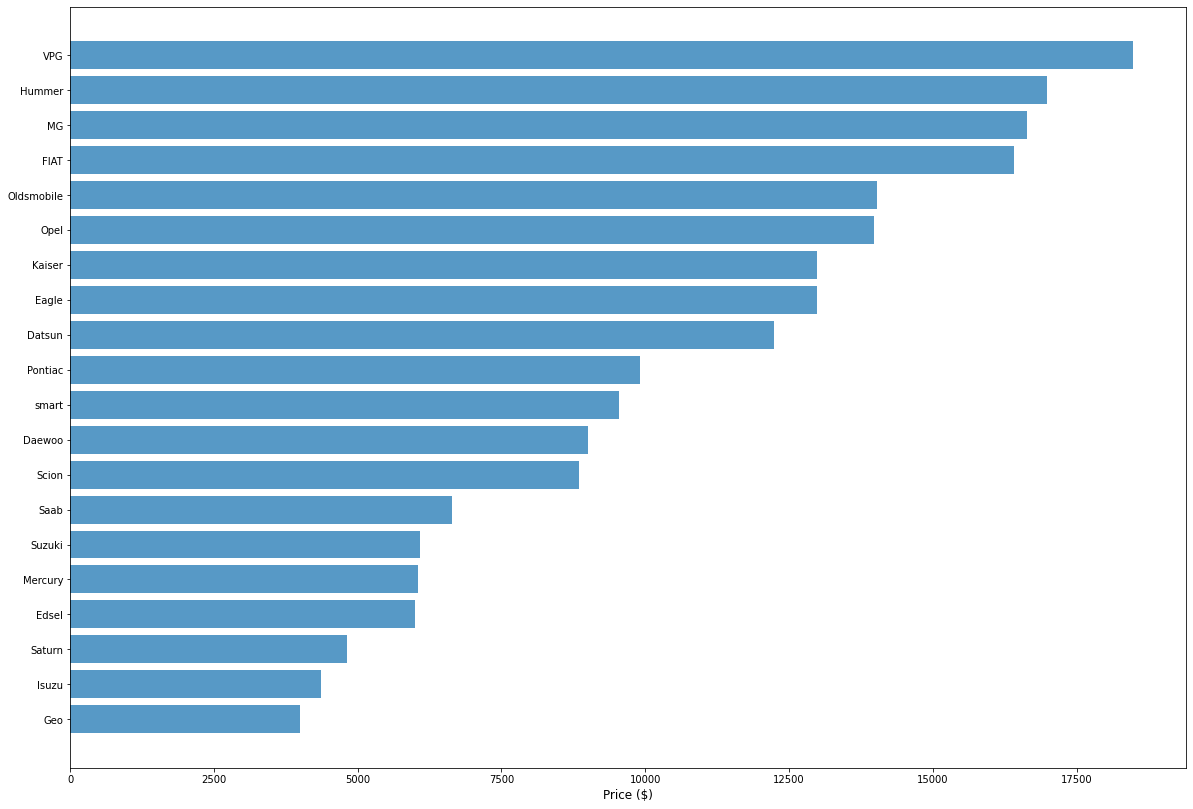

In [ ]:
plt.figure(figsize = (20,14))
plt.barh(make_name_gb.index[:20], make_name_gb[:20], alpha=0.75, )
plt.xlabel('Price ($)', fontsize=12);

Here are the 20 most expensive makes. There are some noticable names here which is really interesting. Also Pagani makes some really expensive vehicles.

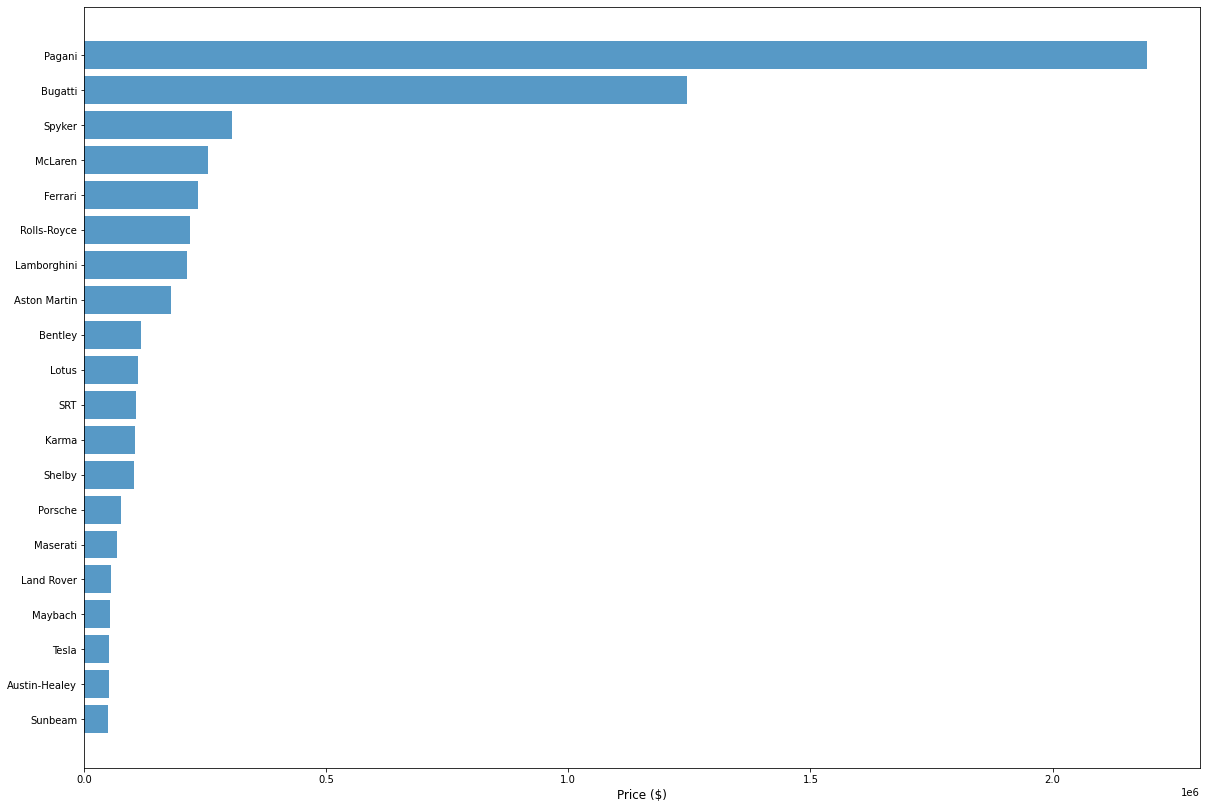

In [ ]:
plt.figure(figsize = (20,14))
plt.barh(make_name_gb.index[60:], make_name_gb[60:], alpha=0.75, )
plt.xlabel('Price ($)', fontsize=12);

Overall, make name and body type seem to play some role in the price.

### How does time on the market play a role in price?

Below is a plot of time on the market by price. Some outliers make this plot hard to interpret.

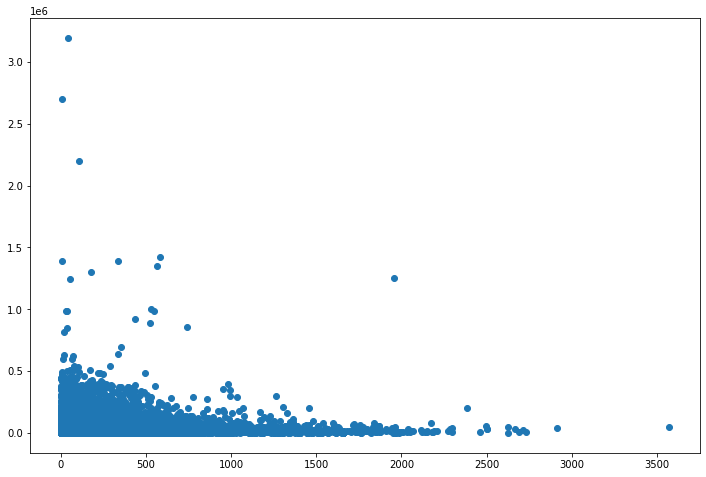

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(df_cleaned['daysonmarket'], df_cleaned['price']);

Let's take away the outliers so we can zoom in on the bottom. 

In [ ]:
df_small = df_cleaned[df_cleaned['rounded_price'] <= 500000]

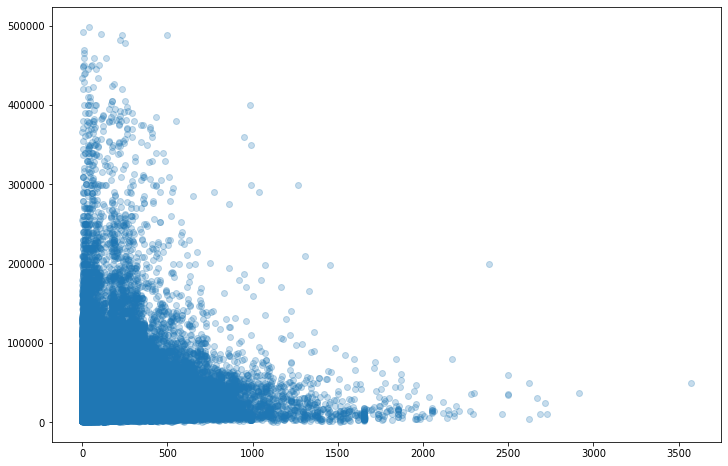

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(df_small['daysonmarket'], df_small['price'], alpha = .25);

As we can see, the less time on the market it seems to show a higher price but also there does seem to be a large amount of low price cars with little time on the market. Let's see what the models think.

##Saving the Data for the Model

Remove the hashtag to run.

In [ ]:
#df_cleaned.to_csv(drive_dir + 'data/df_model2.csv', index=False)

In [ ]:
del df_cleaned

## Models

Below are 2 models. One is XGBoost and the other is K-Nearest Neighbors. Lastly, we ensembled them to get to our final model.

### Preprocessing

Loading in the data we had saved previously for the model.

In [ ]:
df = pd.read_csv(drive_dir + 'data/df_model2.csv')

We need to drop the columns associated with price to not give the model hints.

In [ ]:
df = df.drop('rounded_price', axis='columns')
df = df.drop('percentile', axis='columns')

Also we only care about used cars that are under $50,000 and greater than the year 2000. This is because of a lack of data as well as what we feel like the need of the used car buyer/seller is.

In [ ]:
df = df[df['price'] <= 50000]
df = df[df['owner_count'] > 0]
df = df[df['year'] >= 2000]

In [ ]:
df_inputs = df #This is for the inputs later

####Encoding

Now we will label encode so the model can use our dataframe.

In [ ]:
df_encoded = df

In [ ]:
for c in df_encoded.columns:
  if c != 'price':  #default is fine; not sure if this line is necessary
    if df_encoded[c].dtype == object:  
        try:  
            le = LabelEncoder()           
            le.fit(df_encoded[c].unique())    
            df_encoded[c] = le.transform(df_encoded[c])  
        except Exception as e:         
            print(c)         
            print(e)

####Split the data into training and testing sets

And we can split our data 0.75 for the training set and 0.25 for the testing set.

In [ ]:
y = df_encoded.price
X = df_encoded.drop(['price'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=123)

This saves the training and testing sets. Remove the hastags to run.

In [ ]:
#train_X.to_csv(drive_dir + 'data/train_X.csv', index=False)
#train_y.to_csv(drive_dir + 'data/train_y.csv', index=False)
#test_X.to_csv(drive_dir + 'data/test_X.csv', index=False)
#test_y.to_csv(drive_dir + 'data/test_y.csv', index=False)

### XGBoost With All Columns

Now we can run the first model with all the columns to see which columns the model thinks are most important in predicting price.

In [ ]:
model = xgb.XGBRegressor()
train_model = model.fit(train_X, train_y)

[20:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


####Feature Importances

Below is our feature impotances. As we can see things like horsepower, year, mileage, fuel tank volume are important.

In [ ]:
featuredf = pd.DataFrame(train_model.feature_importances_, train_X.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=False)

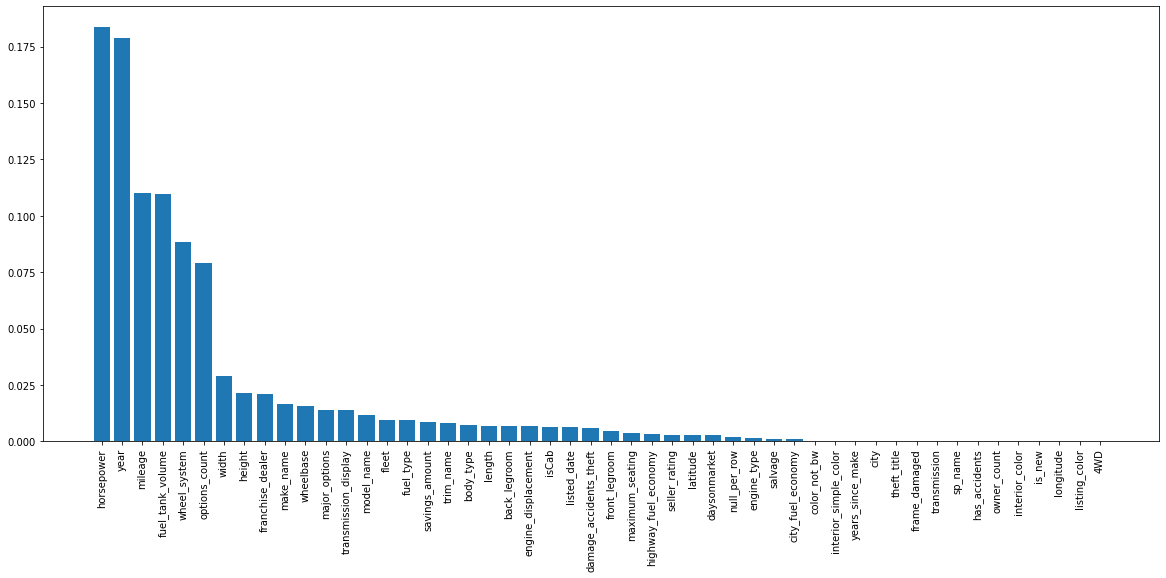

In [ ]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.bar(x, y)
plt.xticks(rotation=90);

After this we did a grid search for the K-nearest Neighbors model to determine which columns they had in common and which we wanted to use in our predictions. Below is the functions that accomplished this. I would not run all of this as it will take a very long time.

In [ ]:
#returns the best neighbors using grid search
def knn_max_acc(start,n,train_X,train_y):

  #create new a knn model
  knn_regg = KNeighborsRegressor()
  #create a dictionary of all values we want to test for n_neighbors
  param_grid = {'n_neighbors': np.arange(start, n)}
  #use gridsearch to test all values for n_neighbors
  knn_gscv = GridSearchCV(knn_regg, param_grid, cv=5)
  #fit model to data
  knn_gscv.fit(train_X, train_y)
  knn_gscv.best_params_

In [ ]:
def powerset(s):
  x = len(s)
  ps = []
  for i in range(1 << x):
       ps.append([s[j] for j in range(x) if (i & (1 << j))])
  
  return ps[1:]

In [ ]:
#Returns best columns based on mean abs error
all_cols = ['horsepower', 'mileage', 'wheel_system', 'year', 
            'owner_count', 'height', 'engine_type', 'city_fuel_economy', 
            'options_count', 'width', 'engine_displacement', 'make_name']

def best_features(train_X, train_y, test_X, test_y, n=5):
  best_cols = None
  best_error = np.infty
  knn_reg = KNeighborsRegressor(n_neighbors = n)
  for cols in powerset(all_cols):
      knn_reg.fit(train_X[cols], train_y)
      test_X_col = test_X[cols]
      test_y_col = test_y
      test_pred = knn_reg.predict(test_X_col)
      error = mean_absolute_error(test_y_col, test_pred)
      if error < best_error:
          best_error = error
          best_cols = cols
#  return best_cols, best_error
  return best_cols

In [ ]:
#Used bc training data is 336970 rows
n_rows = 33697
n_chunks_to_load = 10

Warning: This next cell will take very long to run.

In [ ]:
#getting best columns
best_params_list = []
for i in range(n_chunks_to_load):
  sample_X = pd.read_csv(drive_dir + 'data/train_X.csv', nrows=n_rows, skiprows= range(1, (i)*n_rows+1))
  sample_y = pd.read_csv(drive_dir + 'data/train_y.csv', nrows=n_rows, skiprows= range(1, (i)*n_rows+1))
  best_params_list.append(best_features(sample_X, sample_y, test_X, test_y))

In [ ]:
#getting best neighbors
n_neighbors_list = []

# Instantiate the model
knn_reg = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(5, 15)}
knn_gscv = GridSearchCV(knn_reg, param_grid, cv=5, scoring = 'neg_mean_absolute_error')

# Load data, train the model, repeat
for i in range(n_chunks_to_load):
  sample_X = pd.read_csv(drive_dir + 'data/train_X.csv', nrows=n_rows, skiprows= range(1, (i)*n_rows+1))
  sample_y = pd.read_csv(drive_dir + 'data/train_y.csv', nrows=n_rows, skiprows= range(1, (i)*n_rows+1))
  X = sample_X[['horsepower', 'wheel_system', 'year', 'owner_count', 'height', 'engine_type', 'city_fuel_economy', 'width', 'make_name']]
  y = sample_y['price']
  knn_gscv.fit(X, y)
  neighbors = knn_gscv.best_params_
  n_neighbors_list.append(neighbors['n_neighbors'])

### XGBoost Only Important Columns

Below are the 9 columns that performed the best for both models and worked best ensembled together.

In [ ]:
columns = ['horsepower', 'wheel_system', 'year', 'owner_count', 'height', 'engine_type', 'city_fuel_economy', 'width', 'make_name', 'price']

Now we can make a new train and test set with only these columns so that we are then able to run it through the models.

In [ ]:
df_encoded = df_encoded[columns]

In [ ]:
y = df_encoded.price
X = df_encoded.drop(['price'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=123)

Let's retrain our model.

In [ ]:
model = xgb.XGBRegressor()
train_model1 = model.fit(train_X, train_y)

[21:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


This will save the model for the input stage.

In [ ]:
import joblib 
#joblib.dump(train_model1, drive_dir + 'XGB_model.joblib')

This is mean absolute percentage error. We will end up using this to evaluate our models.

In [ ]:
def mean_abs_pct_error(test_y, y_pred):
  return np.mean(np.abs((test_y - y_pred) / test_y)) * 100

As we can see the XGBoost has a mean absolute error of around \$2679 as well as a percentage error of 15.6%.

In [ ]:
preds_y = train_model1.predict(test_X)
mean_absolute_error(test_y, preds_y)

2676.1906437933267

In [ ]:
mean_abs_pct_error(test_y, preds_y)

15.675228992743609

Now we can plot the predictions vs the actual prices and we get a relatively straight line. We can also see that the worst predictions are at the \$50,000 mark.

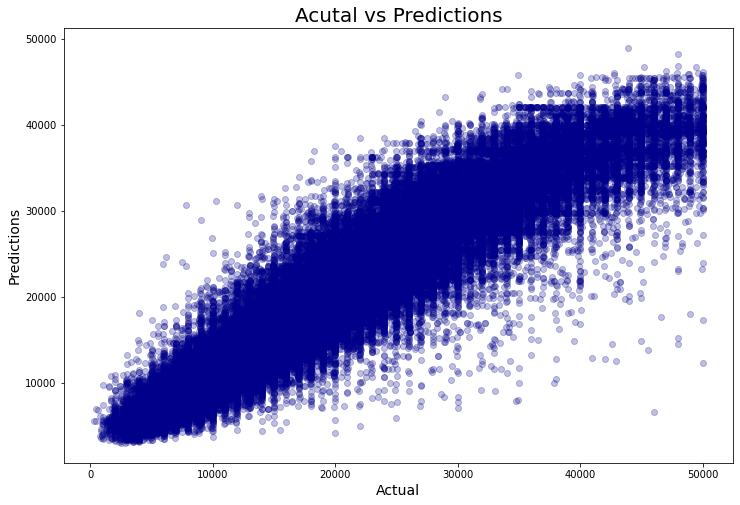

In [ ]:
plt.figure(figsize = (12,8))
plt.scatter(x=test_y,y=preds_y, c='DarkBlue', alpha = .25)
plt.title('Acutal vs Predictions', fontsize = 20)
plt.ylabel('Predictions', fontsize=14)
plt.xlabel('Actual', fontsize=14);

### Nearest Neighbors Only Important Columns

Going forward now we are doing the same thing but using the K-Nearest Neighbors Model. We will also use the same columns as before.

In [ ]:
feat_cols = ['horsepower', 'wheel_system', 'year', 'owner_count', 'height', 'engine_type', 'city_fuel_economy', 'width', 'make_name']

test_X_knn = test_X[feat_cols]

Now to be able to run this model in a timely manner, we will load the data in chunks and make a model for each of the chunks. The chunks will then predict test_X and save those predictions in the prediction_df. Lastly, the prediction_df will contain a mean of all of those predictions from the chunks.

In [ ]:
#ensembling all 10 knn model predictions
prediction_df = pd.DataFrame() 


# Load data, train the model, repeat
# for i, neighbor in enumerate(n_neighbors_list):
knn_reg = KNeighborsRegressor(n_neighbors=5)
for i in range(n_chunks_to_load):
  sample_X = pd.read_csv(drive_dir + 'data/train_X.csv', nrows=n_rows, skiprows= range(1, (i)*n_rows+1))
  sample_y = pd.read_csv(drive_dir + 'data/train_y.csv', nrows=n_rows, skiprows= range(1, (i)*n_rows+1))
  X = sample_X[['horsepower', 'wheel_system', 'year', 'owner_count', 'height', 'engine_type', 'city_fuel_economy', 'width', 'make_name']]
  y = sample_y['price']
  knn_reg.fit(X, y)
  prediction_df[f'prediction {i}'] = knn_reg.predict(test_X_knn)

Here we have the mean and acutal predictions in their own columns.

In [ ]:
prediction_df['mean_pred'] = prediction_df.iloc[:, 0:10].mean(axis=1)

In [ ]:
test_y = test_y.reset_index()

In [ ]:
prediction_df['actual'] = test_y['price']

Take a look at the prediction_df from the K-Nearest Neighbors model.

In [ ]:
prediction_df.head()

,prediction 0,prediction 1,prediction 2,prediction 3,prediction 4,prediction 5,prediction 6,prediction 7,prediction 8,prediction 9,mean_pred,actual
0,28296.2,26674.6,27767.6,25596.2,28131.8,29394.6,29880.2,30456.6,26954.6,25644.4,27879.68,29500.0
1,20581.8,18440.0,21366.6,19660.4,19153.8,20936.4,20002.6,20288.6,19870.8,20528.4,20082.94,19254.0
2,16215.4,16367.0,16497.2,16093.4,16388.4,17326.2,16892.6,16869.4,15525.8,16809.2,16498.46,15922.0
3,23898.6,24236.4,23701.4,23709.4,23859.6,24793.6,24704.6,24171.4,25025.4,24939.6,24304.00,22988.0
4,13194.8,13313.0,13320.4,13910.2,15157.2,13026.2,13194.8,12696.0,12716.2,12991.4,13352.02,15400.0


Furthermore, we can see the mean absolute error is \$2139 and the percetage error is 11.80%.

In [ ]:
mean_absolute_error(prediction_df['actual'], prediction_df['mean_pred'])

2139.815497418134

In [ ]:
mean_abs_pct_error(prediction_df['mean_pred'], prediction_df['actual'])

11.802032965112193

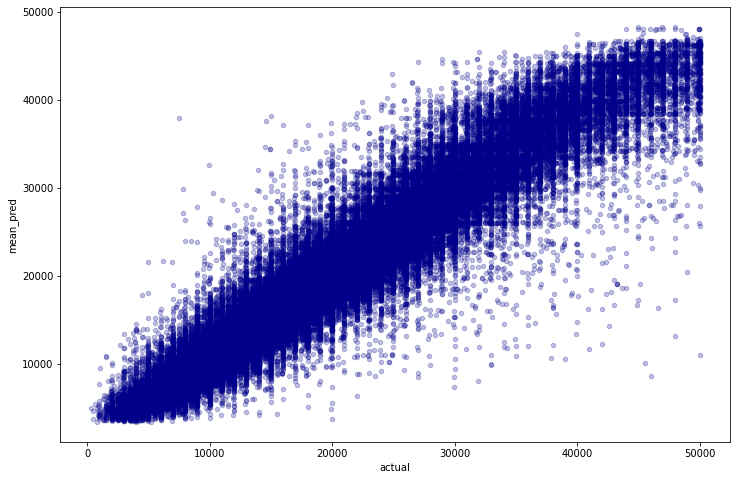

In [ ]:
prediction_df.plot.scatter(x='actual',y='mean_pred', c='DarkBlue', alpha = .25, figsize = (12,8))

### Ensemble

Going forward, we decided to ensemble these two models and compare the results. We did see an improvement in the results so we will end up using this model for our inputs.

####Loading Models

In [ ]:
knn_model0 = joblib.load(drive_dir + f'models/knn_model0.joblib')
knn_model1 = joblib.load(drive_dir + f'models/knn_model1.joblib')
knn_model2 = joblib.load(drive_dir + f'models/knn_model2.joblib')
knn_model3 = joblib.load(drive_dir + f'models/knn_model3.joblib')
knn_model4 = joblib.load(drive_dir + f'models/knn_model4.joblib')
knn_model5 = joblib.load(drive_dir + f'models/knn_model5.joblib')
knn_model6 = joblib.load(drive_dir + f'models/knn_model6.joblib')
knn_model7 = joblib.load(drive_dir + f'models/knn_model7.joblib')
knn_model8 = joblib.load(drive_dir + f'models/knn_model8.joblib')
knn_model9 = joblib.load(drive_dir + f'models/knn_model9.joblib')
knn_model10 = joblib.load(drive_dir + f'models/knn_model10.joblib')
knn_model11 = joblib.load(drive_dir + f'models/knn_model11.joblib')

In [ ]:
xg_model = joblib.load(drive_dir + 'models/XGB_model.joblib')

[21:20:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


####Loading predictions made by model

In [ ]:
prediction_df = pd.read_csv(drive_dir + 'data/knn_pred_df.csv')

In [ ]:
xg_pred = np.load(drive_dir + 'xg_preds.npy')

#### Model

We can now go through and find which weights for each model work best for the best predictions.

This makes an ensemble data frame which saves all of our predictions.

In [ ]:
ensemble_df = pd.DataFrame() 

In [ ]:
ensemble_df['knn_pred'] = prediction_df['mean_pred']

In [ ]:
ensemble_df['xgb_pred'] = xg_pred

In [ ]:
ensemble_df['actual'] = prediction_df['actual']

The code below will return the least error with which weight works best for each model.

In [ ]:
best_error = np.infty
best_weight = 0
for weight in np.linspace(0,1,1000):      #Go through the different weights
  ensemble_df['ensemble_pred'] = weight*ensemble_df['knn_pred'] + (1-weight)*ensemble_df['xgb_pred']
  error = mean_abs_pct_error(ensemble_df['actual'],ensemble_df['ensemble_pred'])

  if error < best_error:      #If there error is less than the previous than it saves it
    best_error = error
    best_weight = weight
    
best_weight

0.5475475475475475

In [ ]:
best_error    # Best error we got

11.832315704523582

In [ ]:
mean_absolute_error(ensemble_df['actual'],ensemble_df['ensemble_pred'])

2015.6145156448674

Now we can run our model using the weights we have found from earlier.

In [ ]:
weight = 0.5475475475475475
ensemble_df['ensemble_pred'] = weight*ensemble_df['knn_pred'] + (1-weight)*ensemble_df['xgb_pred']
error = mean_abs_pct_error(ensemble_df['actual'],ensemble_df['ensemble_pred'])

And here is the plot for this ensemble model. The correlation shows that we have a very strong correlation between the actual and predicted values.

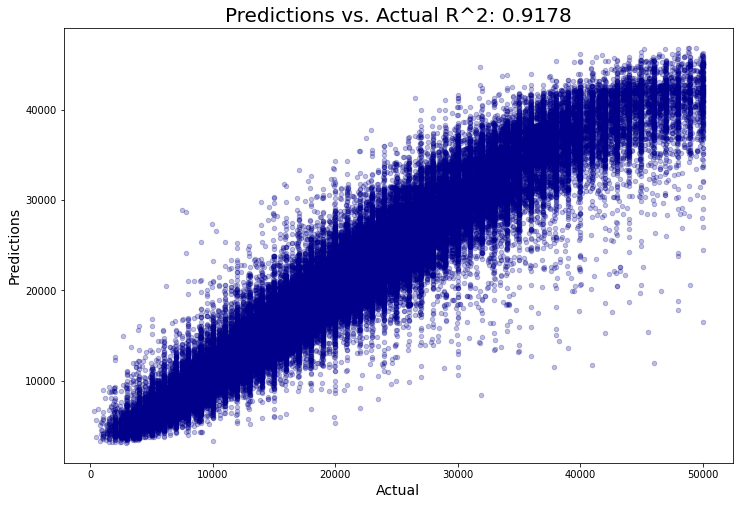

In [ ]:
corr = round(r2_score(ensemble_df['actual'], ensemble_df['ensemble_pred']),4)
ensemble_df.plot.scatter(x='actual',y='ensemble_pred', c='DarkBlue', alpha = .25, figsize = (12,8), title = f"Predictions vs. Actual R^2: {corr}")
plt.title(f"Predictions vs. Actual R^2: {corr}", fontsize=20)
plt.ylabel('Predictions', fontsize=14)
plt.xlabel('Actual', fontsize=14);

## Getting Inputs for Presentation

This final section is where we create a function to get inputs and predict the price of an inputted car for our presentation.

In [ ]:
columns = ['horsepower', 'wheel_system', 'year', 'owner_count', 'height', 'engine_type', 'city_fuel_economy', 'width', 'make_name']

In [ ]:
df_test = df_inputs[columns]

This is the function that gets the user input. We also tossed in some errors where we felt like if the user was to give a wrong answer it could really affect the model.

In [ ]:
def inputs(df):
  columns = ['horsepower', 'wheel_system', 'year', 'owner_count', 'height', 'engine_type', 'city_fuel_economy', 'width', 'make_name']

  while True:
    year = int(input('What year is the car? '))
    if year not in range(1950,2021):
      print(f'Not a valid year. Try Again!')
    else:
      break
  horsepower = input('How much horsepower does your car have? ')
  owner_count = input('How many people have owned the car? ')
  height = input('What is the height of the car? ')
  width = input('What is the width of the car? ')
  city_fuel = input('What is the city fuel economy? ')
  while True:
    wheel_system = input('What is the wheel system? (FWD, AWD, 4WD, RWD, 4X2) ')
    if wheel_system not in ['FWD', 'AWD', '4WD', 'RWD', '4X2']:
      print(f'Not a valid wheel system. Check capitilization and spelling. Try Again!')
    else:
      break
  make = input('What is the make of the car? ')
  engine_type = input('What is the engine type? ')

  #df = df.drop('price', axis='columns')

  my_dict = {'year': [int(year)], 
             'horsepower': [int(horsepower)],
             'height': [int(height)], 
             'owner_count': [int(owner_count)], 
             'wheel_system': [str(wheel_system)],
             'engine_type': [str(engine_type)], 
             'city_fuel_economy': [int(city_fuel)],
             'width': [int(width)],
             'make_name': [str(make)]}

  car = pd.DataFrame.from_dict(my_dict, orient='columns')   #We turned the inputs into a dataframe

  df = pd.concat([df, car])   #Now let's stack it with the original dataframe

  for c in df.columns:    #And we can label encode it so it is the same as the original
    if c != 'price':  
      if df[c].dtype == object:  
          try:  
              le = LabelEncoder()           
              le.fit(df[c].unique())    
              df[c] = le.transform(df[c])  
          except Exception as e:         
              print(c)         
              print(e)

  car = df[-1:]     #Now we just want to return the inputs

  return car

This function puts the car inputs through each model and returns the mean prediction.

In [ ]:
def get_knn(car):

  price_0 = knn_model0.predict(car)
  price_1 = knn_model1.predict(car)
  price_2 = knn_model2.predict(car)
  price_3 = knn_model3.predict(car)
  price_4 = knn_model4.predict(car)
  price_5 = knn_model5.predict(car)
  price_6 = knn_model6.predict(car)
  price_7 = knn_model7.predict(car)
  price_8 = knn_model8.predict(car)
  price_9 = knn_model9.predict(car)
  price_10 = knn_model10.predict(car)
  price_11 = knn_model11.predict(car)

  price_prediction = (price_0 + price_1 + price_2 + price_3 + price_4 + price_5 + price_6 + price_7 + price_8 + price_9 + price_10 + price_11)/12 

  #print(f'Your car is worth ${price_prediction[0]}.')

  return price_prediction[0]

This function goes through the XGBoost model and returns the prediction.

In [ ]:
def get_xg(car):

  price_prediction = xg_model.predict(car)

  #print(f'Your car is worth ${price_prediction[0]}.')

  return price_prediction[0]

Now using the weights we found earlier we can find the predicted price interval from the ensemble model. We make an interval using the mean absolute error divided by two and stretched out on both sides.

In [ ]:
def user_input(df):

  weight = 0.5475475475475475

  users_car = inputs(df)

  knn_predict = get_knn(users_car)

  xg_predict = get_xg(users_car)

  price = weight*knn_predict + (1-weight)*xg_predict

  price_interval_lower = int(price - (2015/2))
  price_interval_higher = int(price + (2015/2))

  print(f'Your car is worth (${round(price_interval_lower,-2)}, ${round(price_interval_higher,-2)}).')

Here is what this looks like when run.

In [ ]:
user_input(df_test)

What year is the car? 2017
How much horsepower does your car have? 425
How many people have owned the car? 1
What is the height of the car? 56
What is the width of the car? 74
What is the city fuel economy? 17
What is the wheel system? (FWD, AWD, 4WD, RWD, 4X2) RWD
What is the make of the car? BMW
What is the engine type? Twin Turbo I6
Your car is worth ($38500, $40500).
